In [1]:
import numpy as np
import sys, os
from imageio.v2 import imread
import pywt
from tqdm import tqdm
from skimage.restoration import denoise_wavelet, estimate_sigma
from functools import partial
# rescale_sigma=True required to silence deprecation warnings
_denoise_wavelet = partial(denoise_wavelet, rescale_sigma=True)
import scipy.stats as stats
from scipy.stats import gmean
import cv2
import matplotlib.pyplot as plt
import pandas as pd


# =========================================================
def rescale(dat,mn,mx):
    """
    rescales an input dat between mn and mx
    """
    m = min(dat.flatten())
    M = max(dat.flatten())
    return (mx-mn)*(dat-m)/(M-m)+mn

##====================================
def standardize(img):
    img = np.array(img)
    #standardization using adjusted standard deviation
    N = np.shape(img)[0] * np.shape(img)[1]
    s = np.maximum(np.std(img), 1.0/np.sqrt(N))
    m = np.mean(img)
    img = (img - m) / s
    img = rescale(img, 0, 1)
    del m, s, N

    return img

In [2]:
print(0.125/resolution)

NameError: name 'resolution' is not defined

In [3]:
image = '/home/casper/Documents/Aardwetenschappen/MSc Thesis/Photo/08_07_22/Location_1/Loc_1_7.jpg'
resolution =  0.036966463
img = cv2.imread(image)
nxx, nyy, _ = img.shape
width = max(nxx, nyy)

x= 0

im = imread(image)   # read the image straight with imread
im = np.squeeze(im)  # squeeze singleton dimensions
if len(np.shape(im))>3:
    im = im[:, :, :3]            # only keep the first 3 bands

if len(np.shape(im))==3: # if rgb, convert to grey
    im = (0.299 * im[:,:,0] + 0.5870*im[:,:,1] + 0.114*im[:,:,2]).astype('uint8')

nx,ny = np.shape(im)
if nx>ny:
    im=im.T

im = standardize(im)

region = im.copy()

original = rescale(region,0,255)

nx, ny = original.shape

P = []; M = []
for k in np.linspace(1,nx-1,100):
    [cfs, frequencies] = pywt.cwt(original[int(k),:], np.arange(3, np.maximum(nx,ny)/(width*resolution / 8), 0.1),  'morl', .5) 
    period = 1. / frequencies
    power =(abs(cfs)) ** 2
    power = np.mean(np.abs(power), axis=1)/(period**2)
    P.append(power)

    M.append(period[np.argmax(power)])

p = np.mean(np.vstack(P), axis=0)
p = np.array(p/np.sum(p))

# get real scales by multiplying by resolution (mm/pixel)
scales = np.array(period)

srt = np.sqrt(np.sum(p*((scales-np.mean(M))**2)))

p = p+stats.norm.pdf(scales, np.mean(M), srt/2)
p = np.hstack([p])
scales = np.hstack([scales])
p = p/np.sum(p)
x = 0
# area-by-number to volume-by-number
r_v = (p*scales**x) / np.sum(p*scales**x) #volume-by-weight proportion

a = (scales*resolution)
minSz = np.array([0, 0.063, 0.125, 0.180, 0.250, 0.300, 0.355, 0.425, 0.500, 0.710, 1, 2, 4, 8])
maxSz = np.array([0.063, 0.125, 0.180, 0.250, 0.300, 0.355, 0.425, 0.500, 0.710, 1, 2, 4, 8, 12])

for i in range(len(minSz)):
    _, length = np.shape(np.where((a>minSz[i])&(a<maxSz[i])))
    print(((np.trapz(np.interp([np.linspace(minSz[i], maxSz[i], 1000)], (scales*resolution), r_v)[0])*length/1000))*100)

0.0
3.6697421808241195
3.867639373382791
4.82832055868302
3.6227457714627564
4.160653174369545
5.020805140172642
5.513820964762265
15.084894931904888
18.184758570820954
30.768168196633017
4.7938385052186305
0.34567190868732406
0.0


In [5]:
print(np.cumsum(r_v))

[0.0014387 0.0028792 0.0043221 ... 0.9999838 0.9999919 1.       ]


In [17]:
percentage = []
if a[0] > 0.063:
    minSz = np.array([0.125, 0.180, 0.250, 0.300, 0.355, 0.425, 0.500, 0.710, 1, 2, 4, 8])
    maxSz = np.array([0.180, 0.250, 0.300, 0.355, 0.425, 0.500, 0.710, 1, 2, 4, 8, 12])

    _, length =  np.shape(np.where(a<0.125))
    percentage.append(((np.trapz(np.interp([np.linspace(a[0], 0.125, 1000)], (scales*resolution), r_v)[0])*length/1000))*100)
    for i in range(len(minSz)):
        _, length = np.shape(np.where((a>minSz[i])&(a<maxSz[i])))   
        percentage.append(((np.trapz(np.interp([np.linspace(minSz[i], maxSz[i], 1000)], (scales*resolution), r_v)[0])*length/1000))*100)

print(percentage)

[3.6768223464055416, 3.867639373382791, 4.82832055868302, 3.6227457714627564, 4.160653174369545, 5.020805140172642, 5.513820964762265, 15.084894931904888, 18.184758570820954, 30.768168196633017, 4.7938385052186305, 0.34567190868732406, 0.0]


In [11]:
a = (scales*resolution)
print(a)
minSz = np.array([0, 0.063, 0.125, 0.180, 0.250, 0.300, 0.355, 0.425, 0.500, 0.710, 1, 2, 4, 8])
maxSz = np.array([0.063, 0.125, 0.180, 0.250, 0.300, 0.355, 0.425, 0.500, 0.710, 1, 2, 4, 8, 12])
_, length = np.shape(np.where((a>minSz[1])&(a<maxSz[1])))
print(np.shape(np.where((a>minSz[1])&(a<maxSz[1]))))

# for i in range(len(minSz)):
#     _, length = np.shape(np.where((a>minSz[i])&(a<maxSz[i])))
#     print(((np.trapz(np.interp([np.linspace(minSz[i], maxSz[i], 2)], (scales*resolution), r_v)[0])*length/2))*100)

[0.06824578 0.09099437 0.11374296 0.13649156 0.15924015 0.18198874
 0.20473733 0.22748593 0.25023452 0.27298311 0.2957317  0.3184803
 0.34122889 0.36397748 0.38672607 0.40947467 0.43222326 0.45497185
 0.47772044 0.50046904 0.52321763 0.54596622 0.56871482 0.59146341
 0.614212   0.63696059 0.65970919 0.68245778 0.70520637 0.72795496
 0.75070356 0.77345215 0.79620074 0.81894933 0.84169793 0.86444652
 0.88719511 0.9099437  0.9326923  0.95544089 0.97818948 1.00093808
 1.02368667 1.04643526 1.06918385 1.09193245 1.11468104 1.13742963
 1.16017822 1.18292682 1.20567541 1.228424   1.25117259 1.27392119
 1.29666978 1.31941837 1.34216696 1.36491556 1.38766415 1.41041274
 1.43316133 1.45590993 1.47865852 1.50140711 1.52415571 1.5469043
 1.56965289 1.59240148 1.61515008 1.63789867 1.66064726 1.68339585
 1.70614445 1.72889304 1.75164163 1.77439022 1.79713882 1.81988741
 1.842636   1.86538459 1.88813319 1.91088178 1.93363037 1.95637896
 1.97912756 2.00187615 2.02462474 2.04737334 2.07012193 2.092870

In [ ]:
np.linspace(2, 4, 2)

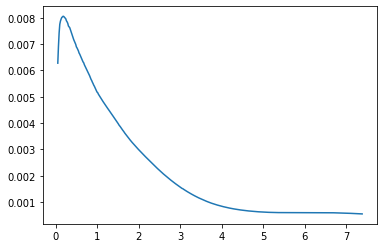

In [5]:
plt.plot((scales*resolution), r_v); plt.show()